In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

df = pd.read_csv('C:/ML/python/data/labeled_data.csv',delimiter=',')

df.dtypes

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\katsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Unnamed: 0             int64
count                  int64
hate_speech            int64
offensive_language     int64
neither                int64
class                  int64
tweet                 object
dtype: object

In [2]:
df.drop(['Unnamed: 0','count'],axis=1,inplace=True)
df.duplicated().sum()

0

<Axes: ylabel='count'>

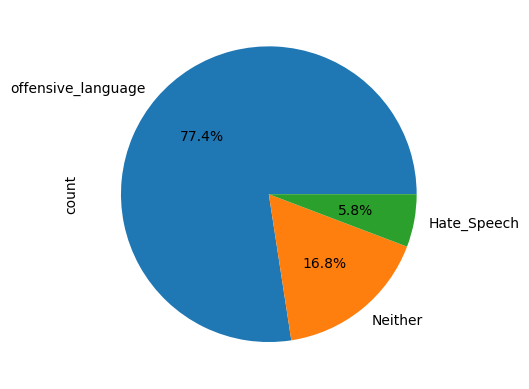

In [3]:


df['sentiment'] = df['class'].map({0:'Hate_Speech',1:'offensive_language',
                                  2: 'Neither'})

df['sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%')


In [4]:
sw = set(stopwords.words("english"))

lemma = WordNetLemmatizer()

def clean_text(text):
    
    text = str(text).lower()
    
    text = re.sub('<.*?>+', '',text)
    
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('rt', '',text)
    text = re.sub('\d', '',text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = re.sub('  ',' ',text)
    
    text = [word for word in text.split('  ') if word not in sw]
    
    text = ' '.join(text)
    
    text = [lemma.lemmatize(word) for word in text.split('  ')]
    
    text = " ".join(text)
    
    return text


df['tweet'] = df['tweet'].apply(clean_text)
df['tweet'].head(10)

0     mayasolovely as a woman you shouldnt complain...
1     mleew boy dats coldtyga dwn bad for cuffin da...
2     urkindofbrand dawg sbabylife you ever fuck a ...
3          cganderson vivabased she look like a tranny
4     shenikarobes the shit you hear about me might...
5    tmadisonx the shit just blows meclaim you so f...
6    brighterdays i can not just sit up and hate on...
7    selfiequeenbri cause im tired of you big bitch...
8     amp you might not get ya bitch back amp thats...
9     rhythmixx hobbies include fighting mariam\n\n...
Name: tweet, dtype: object

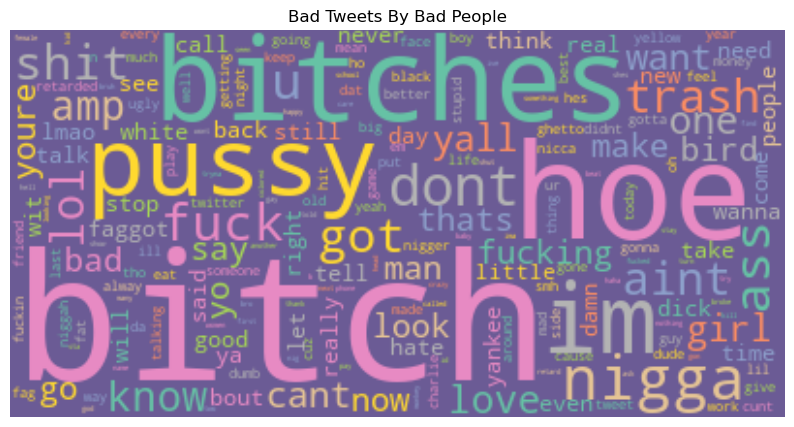

In [5]:
text = " ".join(i for i in df.tweet)

wordcloud = WordCloud(
    background_color="#6B5B95",
    colormap="Set2",
    collocations=False).generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Bad Tweets By Bad People")
plt.show()




In [6]:
#I did not come up with this
# I did not say this
# this is public domain
# I did not say these words
#these people did and shame you them(you possibly)


print(text.count("bitch"))
print(text.count("bitches"))
print(text.count("nigga"))
print(text.count("niggas"))
print(text.count("hoe"))
print(text.count("trash"))
print(text.count("pussy"))
print(text.count("fuck"))
print(text.count("fucking"))
print(text.count("love"))
print(text.count("faggot"))

11597
3133
2489
817
4561
1188
2185
2754
654
951
547


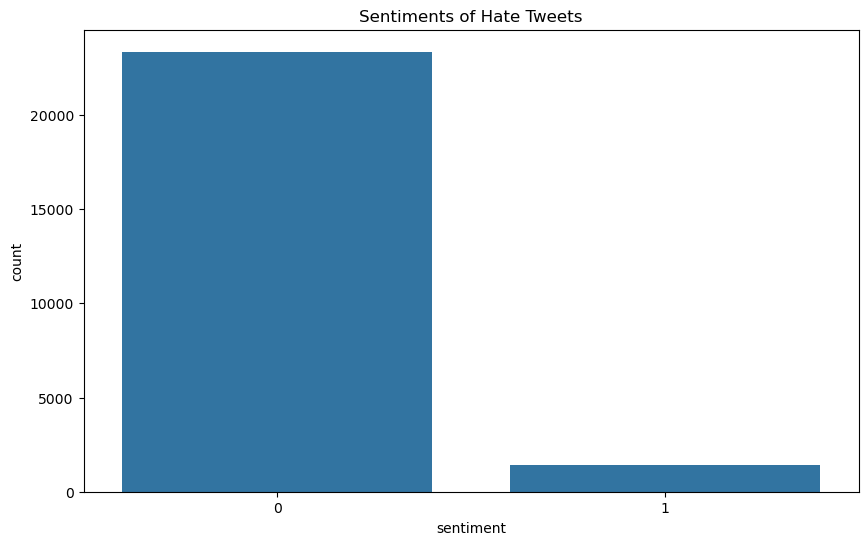

In [7]:
Hate_tweet = (df['sentiment'] == "Hate_Speech").astype('int32')
Hate_tweet.describe()

offensive_tweets = (df['sentiment'] == "offensive_language").astype('int32')
offensive_tweets.describe()

neither = (df['sentiment'] == "Neither").astype('int32')
neither.value_counts()

#ok, more uncessary hatred


plt.figure(figsize=(10,6))
sns.countplot(x=Hate_tweet)
plt.title("Sentiments of Hate Tweets")
plt.xticks()
plt.show()

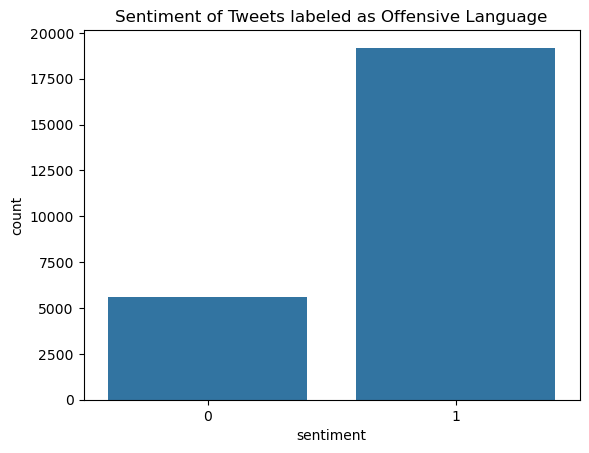

In [8]:
sns.countplot(x=offensive_tweets)
plt.title("Sentiment of Tweets labeled as Offensive Language")
plt.show()


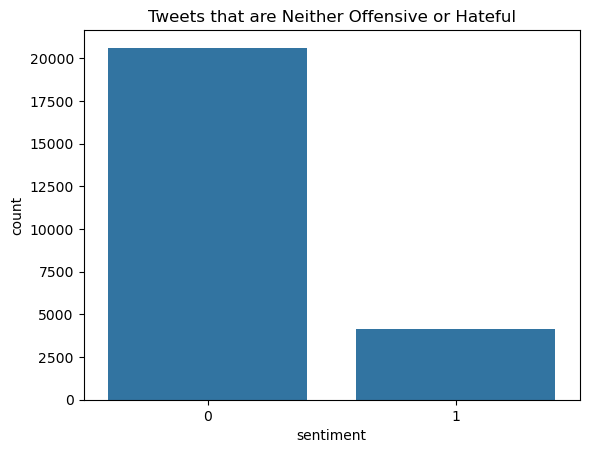

In [9]:
sns.countplot(x=neither)
plt.title("Tweets that are Neither Offensive or Hateful")
plt.show()


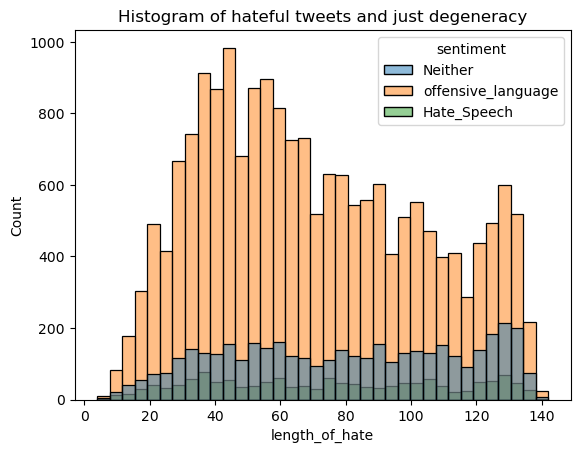

In [10]:
#length of tweets


df['length_of_hate'] = df['tweet'].apply(len)

sns.histplot(x='length_of_hate',hue='sentiment',data=df)
plt.title('Histogram of hateful tweets and just degeneracy')
plt.show()



In [11]:
#Train/test split without keras first
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

X_ = df['tweet']
X_ = cv.fit_transform(X_).toarray()
y_ = df['class']
X_train,X_test,y_train,y_test = train_test_split(X_,y_,test_size=.20,random_state=42)


from sklearn.naive_bayes import MultinomialNB,BernoulliNB
BNB = BernoulliNB()
MNB = MultinomialNB()


from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
lr = LogisticRegression()
PA = PassiveAggressiveClassifier()


from sklearn.metrics import accuracy_score,classification_report


def evaluate_model(X_train,X_test,y_train,y_test,model):
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test,pred)
    clf_rpt = classification_report(y_test,pred)
    print(f'{model.__class__.__name__}, --Accuracy-- {acc*100:.2f}%; --Clf RPT-- {clf_rpt}')
    return pred

lr_pred = evaluate_model(X_train, X_test, y_train, y_test, lr)
PA_pred = evaluate_model(X_train, X_test, y_train, y_test, PA)
MNB_pred = evaluate_model(X_train, X_test, y_train, y_test, MNB)
BNB_pred = evaluate_model(X_train, X_test, y_train, y_test, BNB)

LogisticRegression, --Accuracy-- 89.69%; --Clf RPT--               precision    recall  f1-score   support

           0       0.47      0.22      0.30       290
           1       0.93      0.95      0.94      3832
           2       0.83      0.87      0.85       835

    accuracy                           0.90      4957
   macro avg       0.74      0.68      0.70      4957
weighted avg       0.88      0.90      0.89      4957

PassiveAggressiveClassifier, --Accuracy-- 87.13%; --Clf RPT--               precision    recall  f1-score   support

           0       0.38      0.34      0.36       290
           1       0.91      0.94      0.92      3832
           2       0.83      0.76      0.79       835

    accuracy                           0.87      4957
   macro avg       0.71      0.68      0.69      4957
weighted avg       0.87      0.87      0.87      4957

MultinomialNB, --Accuracy-- 85.90%; --Clf RPT--               precision    recall  f1-score   support

           0       0

In [12]:
#ok keras tokenizer now
X = df['tweet']
y = df['class']


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.15, random_state=42)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Embedding, Dense,SpatialDropout1D
from tensorflow.keras.utils import to_categorical


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index






In [13]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_length = 0
for sequence in X_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length


print("max length",max_length)

max length 33


In [14]:
from tensorflow.keras.utils import pad_sequences

X_train = pad_sequences(X_train,33,padding='post')
X_test = pad_sequences(X_test,33,padding='post')




RNN = Sequential()
RNN.add(Embedding(len(word_index) + 1, output_dim=20, input_length=33))
RNN.add(SpatialDropout1D(0.2))
RNN.add(LSTM(20, dropout=0.2,recurrent_dropout=0.2))
RNN.add(Dense(3, activation='sigmoid'))
RNN.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
batch_size = 64

In [15]:
history = RNN.fit(X_train,y_train,batch_size=batch_size,epochs=10,validation_data=(X_test,y_test))
results = RNN.evaluate(X_test,y_test)
pred = RNN.predict(X_test)
print(results)
print("Accuracy: ",max(history.history['accuracy']))
print("Max vallidation accuracy: ",max(history.history['val_accuracy']))



Epoch 1/10
330/330 [==============================] - 10s 22ms/step - loss: 0.4149 - accuracy: 0.7747 - val_loss: 0.3034 - val_accuracy: 0.8193
Epoch 2/10
330/330 [==============================] - 7s 22ms/step - loss: 0.2447 - accuracy: 0.8614 - val_loss: 0.2452 - val_accuracy: 0.8693
Epoch 3/10
330/330 [==============================] - 7s 21ms/step - loss: 0.1860 - accuracy: 0.9063 - val_loss: 0.2296 - val_accuracy: 0.8739
Epoch 4/10
330/330 [==============================] - 7s 21ms/step - loss: 0.1547 - accuracy: 0.9235 - val_loss: 0.2313 - val_accuracy: 0.8779
Epoch 5/10
330/330 [==============================] - 7s 21ms/step - loss: 0.1329 - accuracy: 0.9318 - val_loss: 0.2586 - val_accuracy: 0.8706
Epoch 6/10
330/330 [==============================] - 7s 21ms/step - loss: 0.1172 - accuracy: 0.9386 - val_loss: 0.2774 - val_accuracy: 0.8564
Epoch 7/10
330/330 [==============================] - 8s 23ms/step - loss: 0.1031 - accuracy: 0.9481 - val_loss: 0.2929 - val_accuracy: 0.856

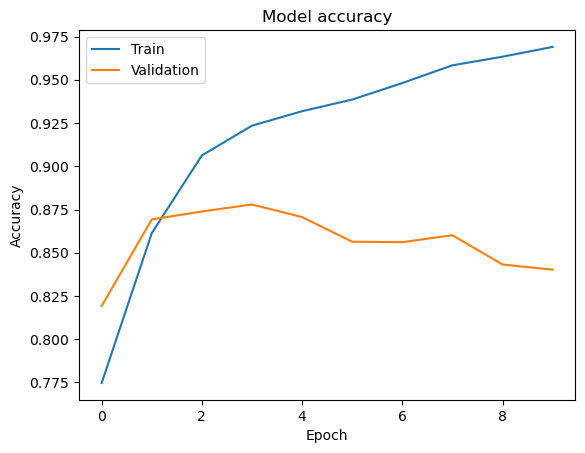

In [16]:
#training and val accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


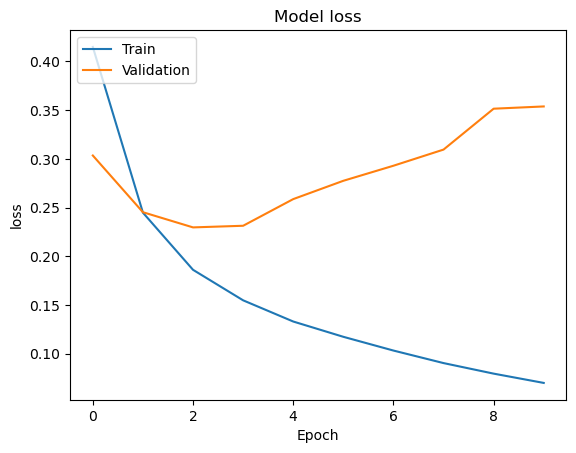

In [17]:

#training and evaluation resluts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
